In [1]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import Onlinehd

SEED = 1234
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

### Load Function MNIST(Digits), FMNIST, EMNIST(Letters)

In [2]:
# loads simple mnist dataset
def load():
    # fetches data
    x, y = sklearn.datasets.fetch_openml('mnist_784', return_X_y=True)
    x = x.astype(np.float)
    y = y.astype(np.int)
    y = np.array(y)

    # split and normalize
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y)
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x, x_test, y, y_test, scaler

# MNIST

## Normalize

OnlineHD is very sensitive to Normalize.
Therefore, it should be applied

In [3]:
x, x_test, y, y_test, scaler = load()

/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_94087/3995914916.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_94087/3995914916.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

In [4]:
x = x.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

scaler = sklearn.preprocessing.Normalizer().fit(x.reshape(-1, 784))
x = torch.tensor(scaler.transform(x.reshape(-1, 784)))
x_test = torch.tensor(scaler.transform(x_test.reshape(-1, 784)))

In [5]:
classes = y.unique().size(0)
features = x.size(1)
model = Onlinehd.OnlineHD(classes, features, dim=10000)

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
model = model.fit(x, y, bootstrap=1.0, lr=0.035, epochs=20)
t = time() - t

Training...
0
10


In [6]:
print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')

Validating...
acc = 0.945410
acc_test = 0.935429
t = 24.358234


# Generate FGSM

In [7]:
def fgsm_attack(x_original, epsilon, gradient):
    # Get Gradient sign
    grad_sign = gradient.sign()
    # Add epsilon*grad_sign perturbation to the original input
    perturbation = epsilon*grad_sign
    x_perturbed = x_original + perturbation
    return x_perturbed, perturbation

In [8]:
import torch.nn as nn
import time

epsilons = torch.Tensor([0.01, 0.03, 0.07, 0.1])
acc_results_non = dict()
verbose = False
criterion = nn.CosineEmbeddingLoss()
N_VAL_SAMPLES = x_test.data.shape[0]

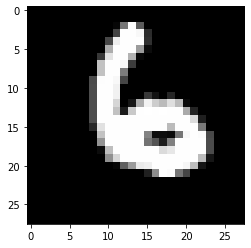

In [9]:
plt.imshow(x_test[-1].reshape(28, 28), cmap='gray')

Training...
0
10


100%|███████████████████████████████████| 17500/17500 [00:15<00:00, 1157.84it/s]


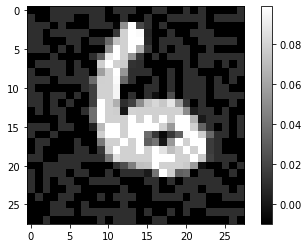


FGSM Attack with epsilon = 0.01000 | Elapsed time: 15.31 seconds.
Accuracy: Before the attack -> 90.06%	|	After the attack -> 63.73%


100%|███████████████████████████████████| 17500/17500 [00:15<00:00, 1097.02it/s]


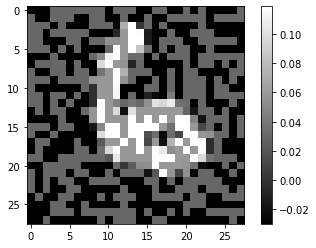


FGSM Attack with epsilon = 0.03000 | Elapsed time: 16.10 seconds.
Accuracy: Before the attack -> 90.06%	|	After the attack -> 13.02%


100%|███████████████████████████████████| 17500/17500 [00:14<00:00, 1175.32it/s]


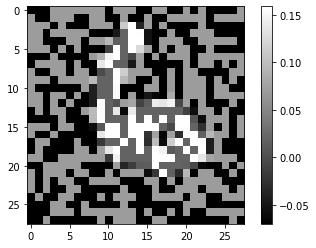


FGSM Attack with epsilon = 0.07000 | Elapsed time: 15.02 seconds.
Accuracy: Before the attack -> 90.06%	|	After the attack -> 9.73%


100%|███████████████████████████████████| 17500/17500 [00:15<00:00, 1138.01it/s]


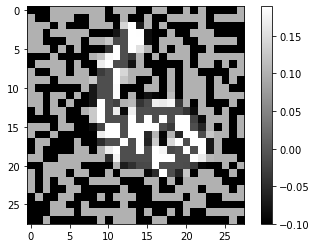


FGSM Attack with epsilon = 0.10000 | Elapsed time: 15.54 seconds.
Accuracy: Before the attack -> 90.06%	|	After the attack -> 9.55%


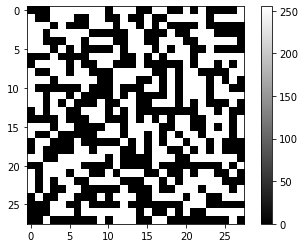

Validating...
acc = 0.912000
acc_test = 0.900571
acc_attack_001 = 0.694800
acc_attack_003 = 0.155257
acc_attack_007 = 0.081600
acc_attack_010 = 0.075257
Training...
0
10


100%|████████████████████████████████████| 17500/17500 [00:17<00:00, 999.64it/s]


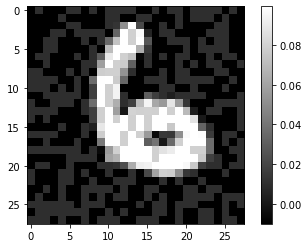


FGSM Attack with epsilon = 0.01000 | Elapsed time: 17.74 seconds.
Accuracy: Before the attack -> 91.82%	|	After the attack -> 80.42%


100%|███████████████████████████████████| 17500/17500 [00:17<00:00, 1017.50it/s]


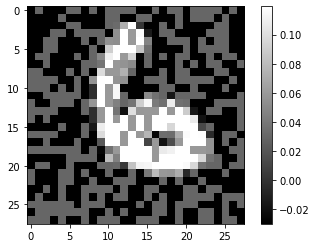


FGSM Attack with epsilon = 0.03000 | Elapsed time: 17.33 seconds.
Accuracy: Before the attack -> 91.82%	|	After the attack -> 13.08%


100%|███████████████████████████████████| 17500/17500 [00:17<00:00, 1028.29it/s]


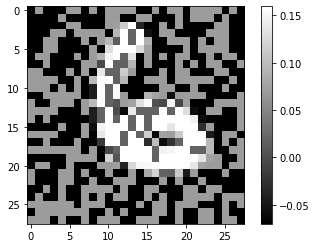


FGSM Attack with epsilon = 0.07000 | Elapsed time: 17.15 seconds.
Accuracy: Before the attack -> 91.82%	|	After the attack -> 9.35%


100%|███████████████████████████████████| 17500/17500 [00:17<00:00, 1018.17it/s]


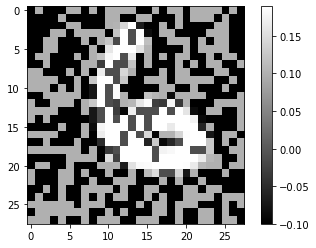


FGSM Attack with epsilon = 0.10000 | Elapsed time: 17.32 seconds.
Accuracy: Before the attack -> 91.82%	|	After the attack -> 9.46%


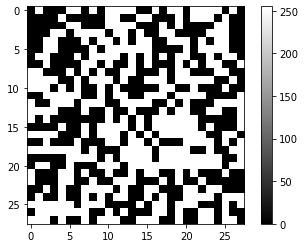

Validating...
acc = 0.929905
acc_test = 0.918171
acc_attack_001 = 0.839257
acc_attack_003 = 0.350629
acc_attack_007 = 0.117257
acc_attack_010 = 0.097714
Training...
0
10


100%|████████████████████████████████████| 17500/17500 [00:19<00:00, 915.58it/s]


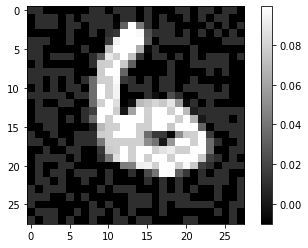


FGSM Attack with epsilon = 0.01000 | Elapsed time: 19.35 seconds.
Accuracy: Before the attack -> 92.39%	|	After the attack -> 84.28%


100%|████████████████████████████████████| 17500/17500 [00:19<00:00, 907.52it/s]


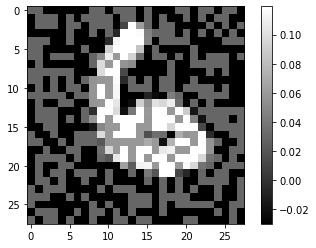


FGSM Attack with epsilon = 0.03000 | Elapsed time: 19.42 seconds.
Accuracy: Before the attack -> 92.39%	|	After the attack -> 14.97%


100%|████████████████████████████████████| 17500/17500 [00:19<00:00, 901.92it/s]


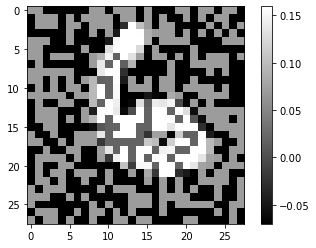


FGSM Attack with epsilon = 0.07000 | Elapsed time: 19.71 seconds.
Accuracy: Before the attack -> 92.39%	|	After the attack -> 9.65%


100%|████████████████████████████████████| 17500/17500 [00:19<00:00, 900.89it/s]


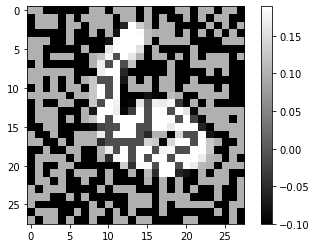


FGSM Attack with epsilon = 0.10000 | Elapsed time: 19.56 seconds.
Accuracy: Before the attack -> 92.39%	|	After the attack -> 9.52%


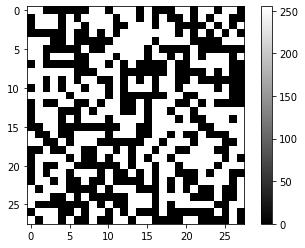

Validating...
acc = 0.935257
acc_test = 0.923886
acc_attack_001 = 0.866343
acc_attack_003 = 0.426743
acc_attack_007 = 0.133714
acc_attack_010 = 0.107200
Training...
0
10


100%|████████████████████████████████████| 17500/17500 [00:21<00:00, 807.33it/s]


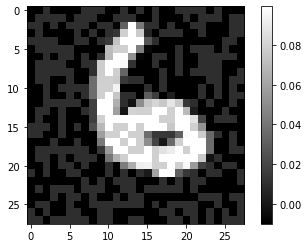


FGSM Attack with epsilon = 0.01000 | Elapsed time: 21.91 seconds.
Accuracy: Before the attack -> 92.79%	|	After the attack -> 86.79%


100%|████████████████████████████████████| 17500/17500 [00:21<00:00, 801.30it/s]


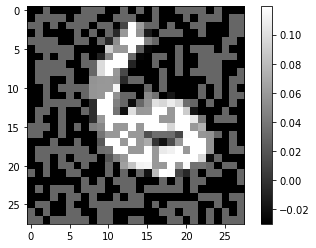


FGSM Attack with epsilon = 0.03000 | Elapsed time: 21.97 seconds.
Accuracy: Before the attack -> 92.79%	|	After the attack -> 17.58%


100%|████████████████████████████████████| 17500/17500 [00:21<00:00, 805.99it/s]


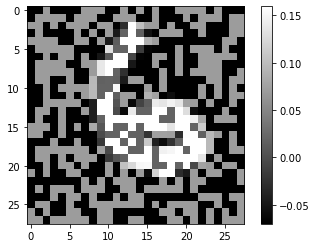


FGSM Attack with epsilon = 0.07000 | Elapsed time: 21.84 seconds.
Accuracy: Before the attack -> 92.79%	|	After the attack -> 9.20%


100%|████████████████████████████████████| 17500/17500 [00:21<00:00, 803.98it/s]


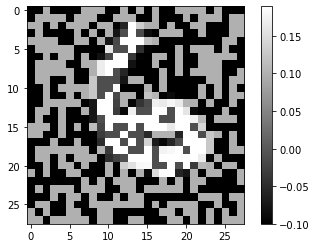


FGSM Attack with epsilon = 0.10000 | Elapsed time: 21.90 seconds.
Accuracy: Before the attack -> 92.79%	|	After the attack -> 9.57%


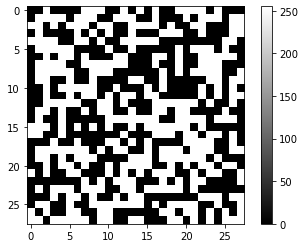

Validating...
acc = 0.938267
acc_test = 0.927943
acc_attack_001 = 0.883314
acc_attack_003 = 0.581771
acc_attack_007 = 0.178857
acc_attack_010 = 0.131429
Training...
0
10


100%|████████████████████████████████████| 17500/17500 [00:27<00:00, 626.78it/s]


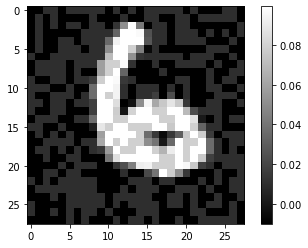


FGSM Attack with epsilon = 0.01000 | Elapsed time: 28.15 seconds.
Accuracy: Before the attack -> 93.21%	|	After the attack -> 88.05%


100%|████████████████████████████████████| 17500/17500 [00:27<00:00, 626.41it/s]


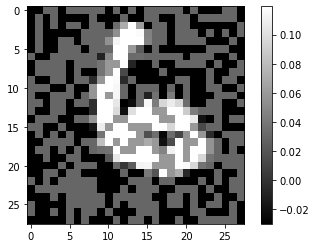


FGSM Attack with epsilon = 0.03000 | Elapsed time: 28.07 seconds.
Accuracy: Before the attack -> 93.21%	|	After the attack -> 19.49%


100%|████████████████████████████████████| 17500/17500 [00:28<00:00, 624.59it/s]


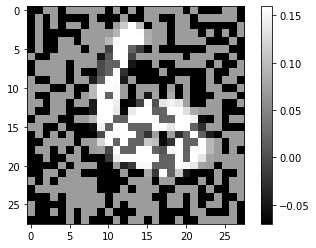


FGSM Attack with epsilon = 0.07000 | Elapsed time: 28.15 seconds.
Accuracy: Before the attack -> 93.21%	|	After the attack -> 9.47%


100%|████████████████████████████████████| 17500/17500 [00:27<00:00, 626.57it/s]


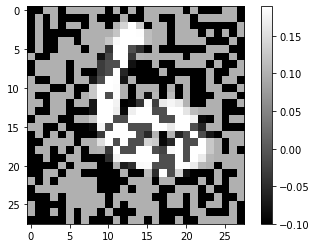


FGSM Attack with epsilon = 0.10000 | Elapsed time: 28.06 seconds.
Accuracy: Before the attack -> 93.21%	|	After the attack -> 9.36%


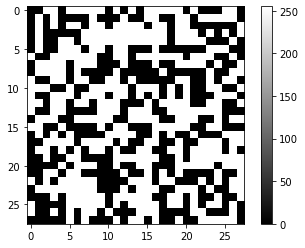

Validating...
acc = 0.940781
acc_test = 0.932057
acc_attack_001 = 0.894914
acc_attack_003 = 0.661029
acc_attack_007 = 0.242057
acc_attack_010 = 0.178000
Training...
0
10


100%|████████████████████████████████████| 17500/17500 [00:31<00:00, 553.13it/s]


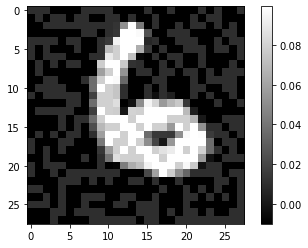


FGSM Attack with epsilon = 0.01000 | Elapsed time: 31.89 seconds.
Accuracy: Before the attack -> 92.89%	|	After the attack -> 88.45%


100%|████████████████████████████████████| 17500/17500 [00:32<00:00, 542.38it/s]


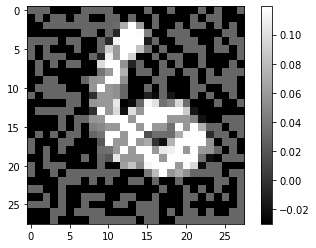


FGSM Attack with epsilon = 0.03000 | Elapsed time: 32.49 seconds.
Accuracy: Before the attack -> 92.89%	|	After the attack -> 20.18%


100%|████████████████████████████████████| 17500/17500 [00:32<00:00, 541.78it/s]


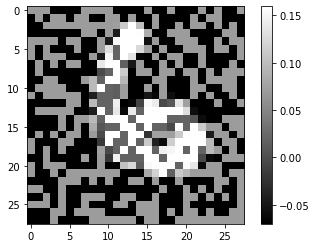


FGSM Attack with epsilon = 0.07000 | Elapsed time: 32.44 seconds.
Accuracy: Before the attack -> 92.89%	|	After the attack -> 9.33%


100%|████████████████████████████████████| 17500/17500 [00:33<00:00, 529.92it/s]


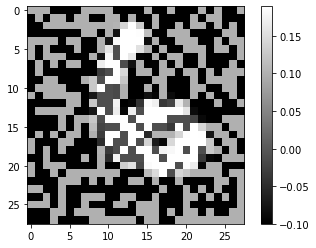


FGSM Attack with epsilon = 0.10000 | Elapsed time: 33.16 seconds.
Accuracy: Before the attack -> 92.89%	|	After the attack -> 9.42%


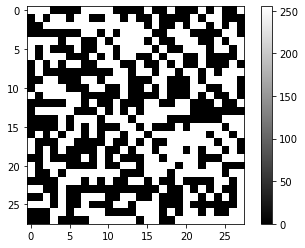

Validating...
acc = 0.940895
acc_test = 0.928857
acc_attack_001 = 0.898286
acc_attack_003 = 0.698800
acc_attack_007 = 0.280914
acc_attack_010 = 0.204800
Training...
0
10


100%|████████████████████████████████████| 17500/17500 [00:42<00:00, 410.59it/s]


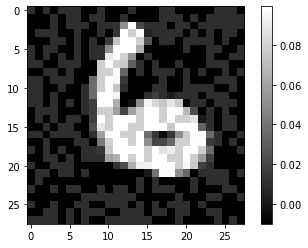


FGSM Attack with epsilon = 0.01000 | Elapsed time: 42.86 seconds.
Accuracy: Before the attack -> 93.12%	|	After the attack -> 89.23%


100%|████████████████████████████████████| 17500/17500 [00:42<00:00, 407.55it/s]


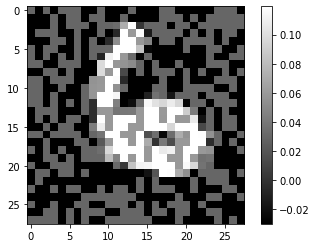


FGSM Attack with epsilon = 0.03000 | Elapsed time: 43.07 seconds.
Accuracy: Before the attack -> 93.12%	|	After the attack -> 21.50%


100%|████████████████████████████████████| 17500/17500 [00:42<00:00, 408.70it/s]


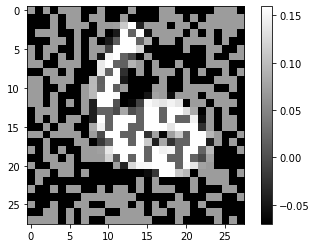


FGSM Attack with epsilon = 0.07000 | Elapsed time: 42.95 seconds.
Accuracy: Before the attack -> 93.12%	|	After the attack -> 9.73%


100%|████████████████████████████████████| 17500/17500 [00:42<00:00, 411.22it/s]


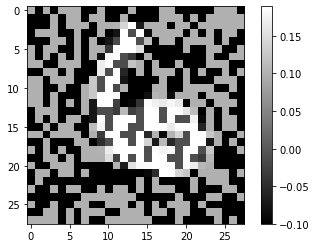


FGSM Attack with epsilon = 0.10000 | Elapsed time: 42.69 seconds.
Accuracy: Before the attack -> 93.12%	|	After the attack -> 9.30%


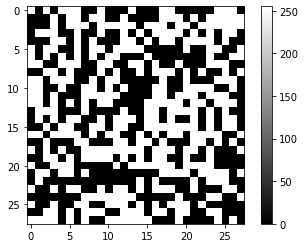

Validating...
acc = 0.941105
acc_test = 0.931200
acc_attack_001 = 0.903200
acc_attack_003 = 0.717943
acc_attack_007 = 0.274629
acc_attack_010 = 0.199543
Training...
0
10


100%|████████████████████████████████████| 17500/17500 [00:48<00:00, 357.93it/s]


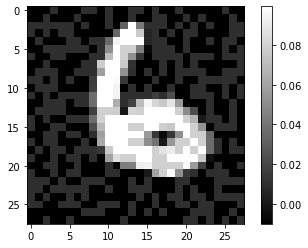


FGSM Attack with epsilon = 0.01000 | Elapsed time: 49.13 seconds.
Accuracy: Before the attack -> 92.94%	|	After the attack -> 89.59%


100%|████████████████████████████████████| 17500/17500 [00:48<00:00, 361.38it/s]


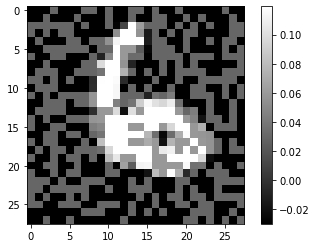


FGSM Attack with epsilon = 0.03000 | Elapsed time: 48.56 seconds.
Accuracy: Before the attack -> 92.94%	|	After the attack -> 24.72%


100%|████████████████████████████████████| 17500/17500 [00:48<00:00, 364.50it/s]


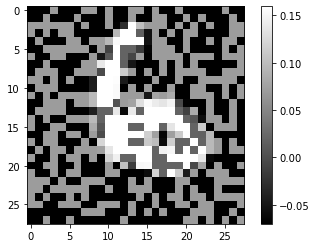


FGSM Attack with epsilon = 0.07000 | Elapsed time: 48.14 seconds.
Accuracy: Before the attack -> 92.94%	|	After the attack -> 9.19%


100%|████████████████████████████████████| 17500/17500 [00:48<00:00, 363.68it/s]


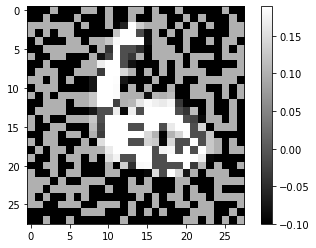


FGSM Attack with epsilon = 0.10000 | Elapsed time: 48.25 seconds.
Accuracy: Before the attack -> 92.94%	|	After the attack -> 9.41%


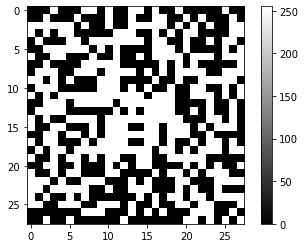

Validating...
acc = 0.942171
acc_test = 0.929429
acc_attack_001 = 0.904629
acc_attack_003 = 0.760571
acc_attack_007 = 0.330171
acc_attack_010 = 0.239086
Training...
0
10


100%|████████████████████████████████████| 17500/17500 [00:56<00:00, 309.81it/s]


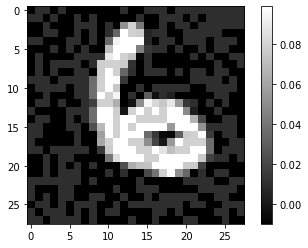


FGSM Attack with epsilon = 0.01000 | Elapsed time: 56.82 seconds.
Accuracy: Before the attack -> 93.27%	|	After the attack -> 90.09%


100%|████████████████████████████████████| 17500/17500 [00:56<00:00, 307.36it/s]


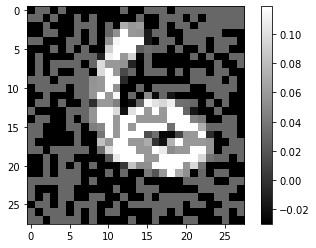


FGSM Attack with epsilon = 0.03000 | Elapsed time: 57.08 seconds.
Accuracy: Before the attack -> 93.27%	|	After the attack -> 26.38%


100%|████████████████████████████████████| 17500/17500 [00:56<00:00, 310.55it/s]


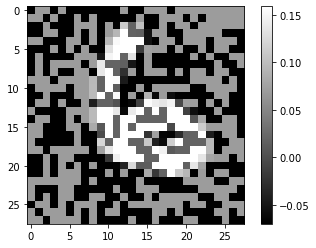


FGSM Attack with epsilon = 0.07000 | Elapsed time: 56.48 seconds.
Accuracy: Before the attack -> 93.27%	|	After the attack -> 9.35%


100%|████████████████████████████████████| 17500/17500 [01:04<00:00, 273.11it/s]


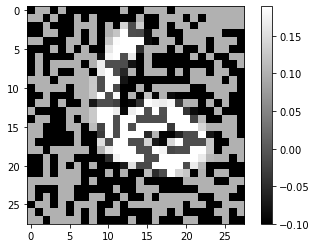


FGSM Attack with epsilon = 0.10000 | Elapsed time: 64.22 seconds.
Accuracy: Before the attack -> 93.27%	|	After the attack -> 9.55%


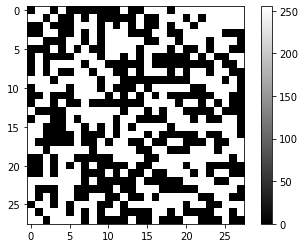

Validating...
acc = 0.942762
acc_test = 0.932743
acc_attack_001 = 0.908629
acc_attack_003 = 0.771486
acc_attack_007 = 0.358343
acc_attack_010 = 0.268171


In [10]:
from tqdm import tqdm
result = []

for dimension in range(500, 5000, 500):
    
    classes = y.unique().size(0)
    features = x.size(1)
    model = Onlinehd.OnlineHD(classes, features, dim=dimension)

    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
        x_test = x_test.cuda()
        y_test = y_test.cuda()
        model = model.to('cuda')
        print('Using GPU!')

    print('Training...')
    model = model.fit(x, y, bootstrap=1.0, lr=0.035, epochs=20)
    
    attack_sample = {'0.01':torch.zeros(17500, 28, 28),
                     '0.03':torch.zeros(17500, 28, 28),
                     '0.07':torch.zeros(17500, 28, 28),
                     '0.1':torch.zeros(17500, 28, 28)}

    for eps in epsilons:
        correct_unperturbed = 0
        correct_perturbed = 0
        t0 = time.perf_counter()

        attack = torch.zeros(17500, 28, 28)
        labels = torch.zeros(17500)
        for j in tqdm(range(len(x_test))):
        ### NOTE: IT WOULD BE MORE EFFICIENT TO ITERATE ONLY ONCE THROUGH THE DATA AND PERFORM ALL THE ATTACKS
            x_origin, y_target = x_test[j], y_test[j]
            x_origin, y_target = x_origin.to(device), y_target.to(device)
            x_origin.requires_grad = True

            y_pred = model(x_origin.reshape(-1, 784))

            if y_pred == y_target:
                correct_unperturbed += 1

            label = torch.ones(classes, dtype=int) * -1
            label[y_target.item()] = 1
            # Calculate loss and gradient
            output = model.encode(x_origin.reshape(-1, 784))
            loss = criterion(output, model.model, label)
            grad = torch.autograd.grad(outputs=loss, inputs=x_origin)[0]

            perturbed_x, pp = fgsm_attack(x_origin, epsilon=eps, gradient=grad)
            perturbed_output = model(perturbed_x.reshape(-1, 784))            

            if perturbed_output == y_target:
                correct_perturbed += 1

            attack[j] = perturbed_x.reshape(28, 28)
            labels[j] = y_target

        if eps == 0.1:
            attack_sample['0.1'] = attack
        elif eps == 0.07:
            attack_sample['0.07'] = attack
        elif eps == 0.03:
            attack_sample['0.03'] = attack
        else:
            attack_sample['0.01'] = attack                

        plt.imshow(perturbed_x.detach().numpy().reshape(28, 28), cmap='gray')
        plt.colorbar()
        plt.show()
        acc_before_attack = correct_unperturbed / N_VAL_SAMPLES
        acc_after_attack = correct_perturbed / N_VAL_SAMPLES
        print(f'\nFGSM Attack with epsilon = {eps:.5f} | Elapsed time: {time.perf_counter() - t0:.2f} seconds.')
        print(f'Accuracy: Before the attack -> {100 * acc_before_attack:.2f}%\t|\tAfter the attack -> {100 * acc_after_attack:.2f}%')
        acc_results_non[eps.item()] = acc_after_attack
    acc_results_non[0] = acc_before_attack

    max_ = pp.max()
    min_ = pp.min()

    pp = ((pp - min_) / (max_ - min_))*255

    plt.imshow(pp.reshape(28, 28), cmap='gray')
    plt.colorbar()
    plt.show()

    for eps in attack_sample.keys():
        attack_norm = attack_sample[eps].detach().numpy().reshape(-1, 784)
        attack_norm = scaler.transform(attack_norm)
        attack_sample[eps] = torch.from_numpy(attack_norm).float()

    print('Validating...')
    yhat = model(x)
    yhat_test = model(x_test)
    yhat_attack_001 = model(attack_sample['0.01'])
    yhat_attack_003 = model(attack_sample['0.03'])
    yhat_attack_007 = model(attack_sample['0.07'])
    yhat_attack_010 = model(attack_sample['0.1'])

    acc = (y == yhat).float().mean()
    acc_test = (y_test == yhat_test).float().mean()
    acc_attack_001 = (labels == yhat_attack_001).float().mean()
    acc_attack_003 = (labels == yhat_attack_003).float().mean()
    acc_attack_007 = (labels == yhat_attack_007).float().mean()
    acc_attack_010 = (labels == yhat_attack_010).float().mean()

    print(f'{acc = :6f}')
    print(f'{acc_test = :6f}')
    print(f'{acc_attack_001 = :6f}')
    print(f'{acc_attack_003 = :6f}')
    print(f'{acc_attack_007 = :6f}')
    print(f'{acc_attack_010 = :6f}')
    
    result.append([dimension, acc, acc_test, acc_attack_001, 
                   acc_attack_003, acc_attack_007, acc_attack_010])

In [15]:
import pandas as pd
tmp = pd.DataFrame(np.array(result), columns=['dimension', 'acc', 'acc_test', 'acc_attack_001', 'acc_attack_003', 
                                            'acc_attack_070', 'acc_attack_010'])

In [16]:
tmp

,dimension,acc,acc_test,acc_attack_001,acc_attack_003,acc_attack_070,acc_attack_010
0,500.0,0.912000,0.900571,0.694800,0.155257,0.081600,0.075257
1,1000.0,0.929905,0.918171,0.839257,0.350629,0.117257,0.097714
2,1500.0,0.935257,0.923886,0.866343,0.426743,0.133714,0.107200
3,2000.0,0.938267,0.927943,0.883314,0.581771,0.178857,0.131429
4,2500.0,0.940781,0.932057,0.894914,0.661029,0.242057,0.178000
5,3000.0,0.940895,0.928857,0.898286,0.698800,0.280914,0.204800
6,3500.0,0.941105,0.931200,0.903200,0.717943,0.274629,0.199543
7,4000.0,0.942171,0.929429,0.904629,0.760571,0.330171,0.239086
8,4500.0,0.942762,0.932743,0.908629,0.771486,0.358343,0.268171


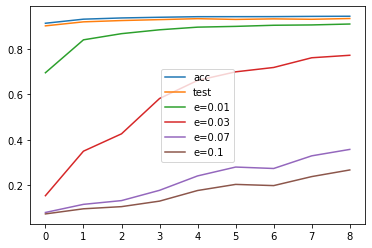

In [39]:
col = tmp.columns

plt.plot(tmp['acc'], label='acc')
plt.plot(tmp['acc_test'], label='test')
plt.plot(tmp['acc_attack_001'], label='e=0.01')
plt.plot(tmp['acc_attack_003'], label='e=0.03')
plt.plot(tmp['acc_attack_070'], label='e=0.07')
plt.plot(tmp['acc_attack_010'], label='e=0.1')

plt.legend()